In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers
import baukit

import os
import sys
sys.path.append("..")

from util import model_utils, misc
from operator import itemgetter

## Loading the model

In [3]:
transformers.__version__

'4.28.0.dev0'

In [4]:
DEVICE = "cuda:0"

In [5]:
weights_path = "/data/arnab_sen_sharma/weights"

# facebook/galactica-6.7b  
# gpt2-{medium,large,xl}
# EleutherAI/gpt-j-6B

# MODEL_NAME = "EleutherAI/gpt-j-6B"
MODEL_NAME = "llama-13b-hf"
MODEL_NAME = f"{weights_path}/{MODEL_NAME}"
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

Loading checkpoint shards:   0%|          | 0/41 [00:00<?, ?it/s]

/data/arnab_sen_sharma/weights/llama-13b-hf ==> device: cuda:0, memory: 26115624960


In [6]:
input_text = "Facebook is a"
tokenized = tokenizer(input_text, return_tensors="pt")

outputs = model.generate(tokenized.input_ids.to(model.device), max_new_tokens=20, top_k = 1)
print(tokenizer.decode(outputs[0]))

/data/arnab_sen_sharma/miniconda3/envs/relations/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


 ⁇  Facebook is a social networking service and website launched in February 2004, operated and privately owned by


In [7]:
txt, ret_dict = model_utils.generate_fast(
    model = model, tok = tokenizer,
    prompts = input_text,
    argmax_greedy= True,
#     debug=True,
    max_new_tokens=30,
    top_k = 5
)

txt

/data/arnab_sen_sharma/Projects/relations/notebooks/../util/model_utils.py:186: UserWarning: The model `<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.
  warnings.warn(f"The model `{type(model)}` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.")


[' ??  Facebook is a social networking service and website launched in February 2004, operated and privately owned by Facebook, Inc. As of. 12']

## Testing for disambiguating relations

In [8]:
sample = [
#     {"fruit": "apple", "inside": "white", "outside": "red"},
    {"fruit": "watermelon", "inside": "red", "outside": "green"},
    {"fruit": "banana", "inside": "white", "outside": "yellow"},
    {"fruit": "coconut", "inside": "white", "outside": "brown"},
#     {"fruit": "kiwi", "inside": "green", "outside": "brown"},
    {"fruit": "cantaloupe", "inside": "orange", "outside": "green"},
    {"fruit": "blood orange", "inside": "red", "outside": "orange"},
    {"fruit": "eggplant", "inside": "white", "outside": "purple"},
    {"fruit": "dragonfruit", "inside": "white", "outside": "pink"},
    {"fruit": "lime", "inside": "white", "outside": "green"},
    {"fruit": "radish", "inside": "white", "outside": "red"},
    {"fruit": "salak", "inside": "white", "outside": "brown"},
]

In [9]:
# prompts = [
#     "What color is the inside of a coconut? It is",
#     "What color is the outside of a coconut? It is",
    
#     "What color is the inside of a watermelon? It is",
#     "What color is the outside of a watermelon? It is",
    
#     "What color is the inside of a kiwi? It is",
#     "What color is the outside of a kiwi? It is",
# ]

icl_inside = """the color on the inside of a apple is white
the color on the inside of a kiwi is green
the color on the inside of a {} is"""

icl_outside = """the color on the outside of a apple is red
the color on the outside of a kiwi is brown
the color on the outside of a {} is"""


for fruit in sample:
    name = fruit["fruit"]
    print(fruit)
    prompts = [icl_inside.format(name), icl_outside.format(name)]
    txt, ret_dict = model_utils.generate_fast(
        model = model, tok = tokenizer,
        prompts = prompts,
        argmax_greedy= True,
        max_new_tokens=5,
        top_k = 5,

        get_answer_tokens = True
    )
    
    inside_pred = [(c["token"], c["token_id"], c["p"]) for c in ret_dict["answer"][0]['candidates']]
    outside_pred = [(c["token"], c["token_id"], c["p"]) for c in ret_dict["answer"][1]['candidates']]
    
    print(name)
    print(f"inside >> {fruit['inside']} || {inside_pred}")
    print(f"outside >> {fruit['outside']} || {outside_pred}")
    print()


{'fruit': 'watermelon', 'inside': 'red', 'outside': 'green'}
watermelon
inside >> red || [('red', 2654, 0.3896), ('white', 4796, 0.2021), ('p', 282, 0.1959), ('green', 7933, 0.0444), ('yellow', 13328, 0.0325)]
outside >> green || [('green', 7933, 0.4868), ('red', 2654, 0.1631), ('p', 282, 0.1157), ('black', 4628, 0.0331), ('yellow', 13328, 0.0297)]

{'fruit': 'banana', 'inside': 'white', 'outside': 'yellow'}
banana
inside >> white || [('yellow', 13328, 0.5356), ('white', 4796, 0.2822), ('green', 7933, 0.0302), ('black', 4628, 0.0133), ('also', 884, 0.0128)]
outside >> yellow || [('yellow', 13328, 0.6621), ('green', 7933, 0.141), ('brown', 17354, 0.0732), ('black', 4628, 0.0191), ('red', 2654, 0.0088)]

{'fruit': 'coconut', 'inside': 'white', 'outside': 'brown'}
coconut
inside >> white || [('white', 4796, 0.6826), ('brown', 17354, 0.0731), ('yellow', 13328, 0.0708), ('orange', 24841, 0.0204), ('green', 7933, 0.0183)]
outside >> brown || [('brown', 17354, 0.4595), ('green', 7933, 0.2311)

## Causal Tracing of disambiguating relations

In [25]:
from util.causal_tracing import (
    predict_token,
    guess_subject,
    find_token_range,
    calculate_hidden_flow,
    plot_trace_heatmap,
    plot_hidden_flow,
    plot_all_flow
)


# prompt = "The Space Needle is located in the city of"
# tokenized = tokenizer([prompt], return_tensors = "pt", padding = True).to(model.device)
# output = model(**tokenized)
# output["logits"]

# predict_token(mt, [prompt], return_p = True)
# subject = guess_subject(prompt).replace(" ", "")
# print(subject)

# find_token_range(tokenizer, tokenized["input_ids"][0], subject)

In [18]:
mt.embedder_name

'model.embed_tokens'

In [16]:
subject = "coconut"
prompt = icl_inside.format(subject)
# prompt = "What is the color on the inside of a {}? It is".format(subject)

# plot_hidden_flow(mt, prompt, subject, modelname = "LLaMa-13b")

In [199]:
hidden_flow = calculate_hidden_flow(mt, prompt, subject)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

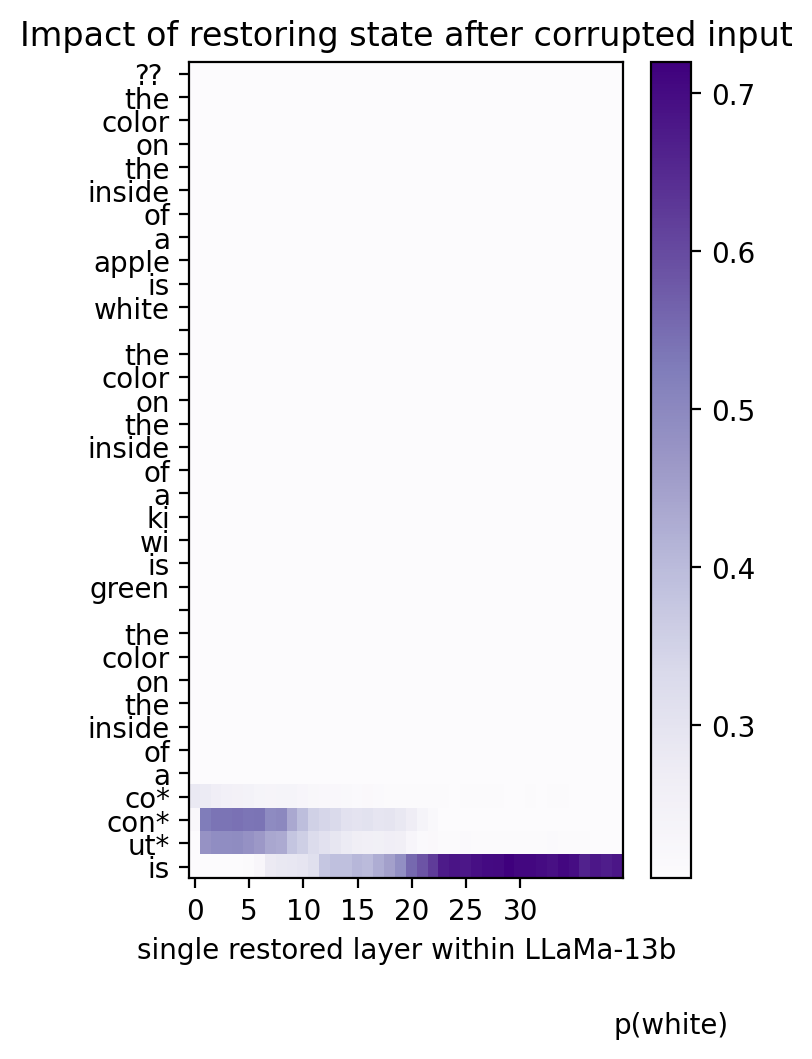

In [254]:
plot_trace_heatmap(hidden_flow, modelname = "LLaMa-13b")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

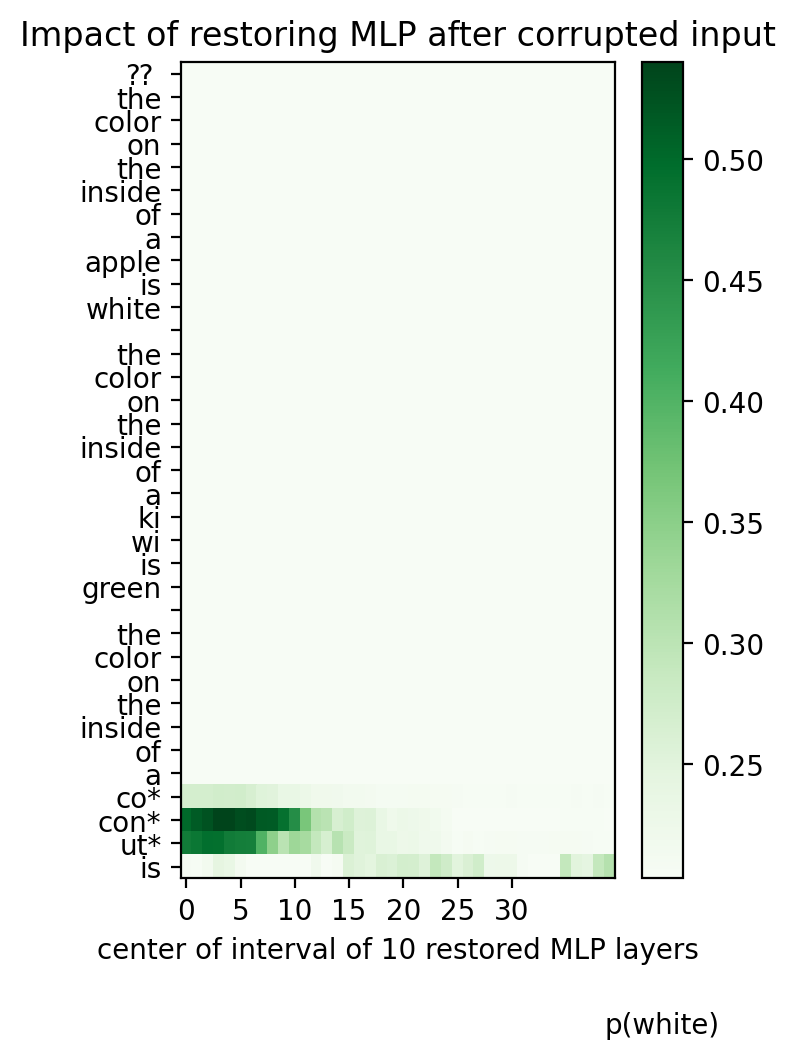

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

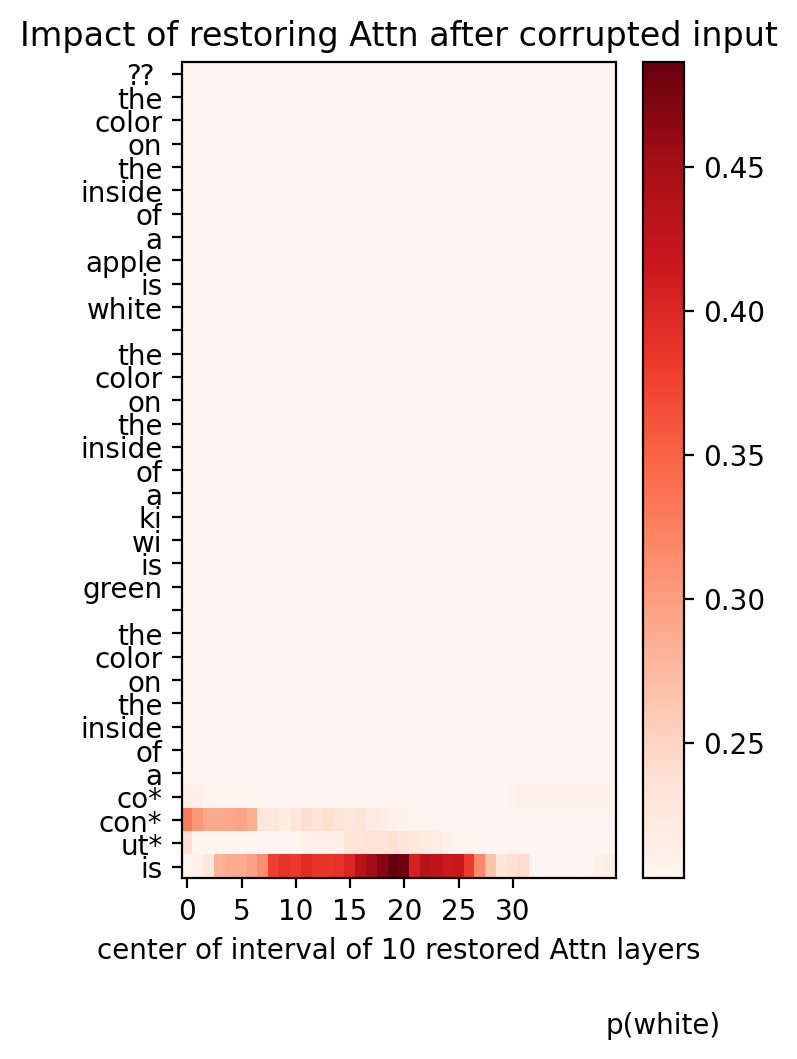

In [ ]:
plot_all_flow(mt, prompt, subject, modelname = "LLaMa-13b")

In [19]:
prompt_2 = "What is the color on the inside of a {}? It is".format(subject)
hidden_flow_2 = calculate_hidden_flow(mt, prompt_2, subject)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

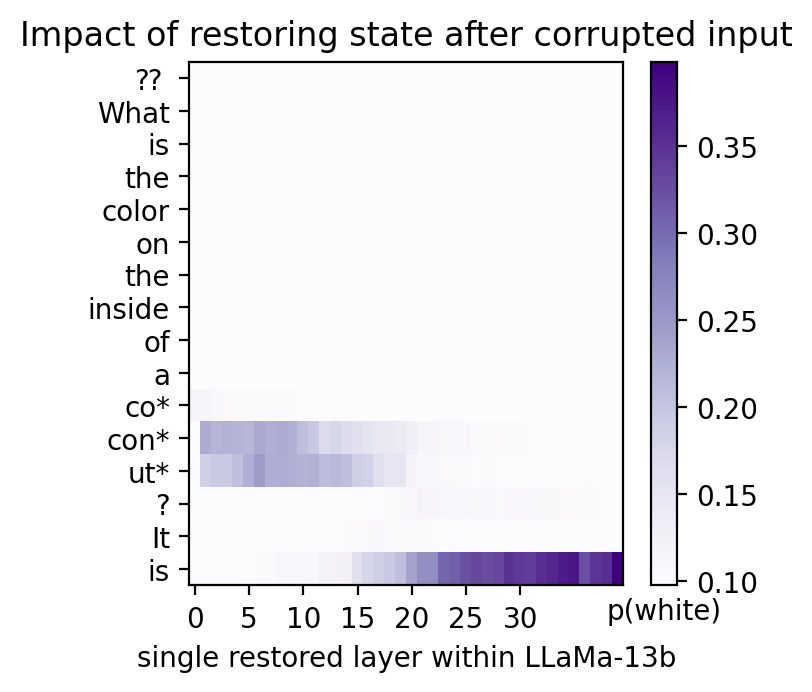

In [20]:
plot_trace_heatmap(hidden_flow_2, modelname = "LLaMa-13b")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

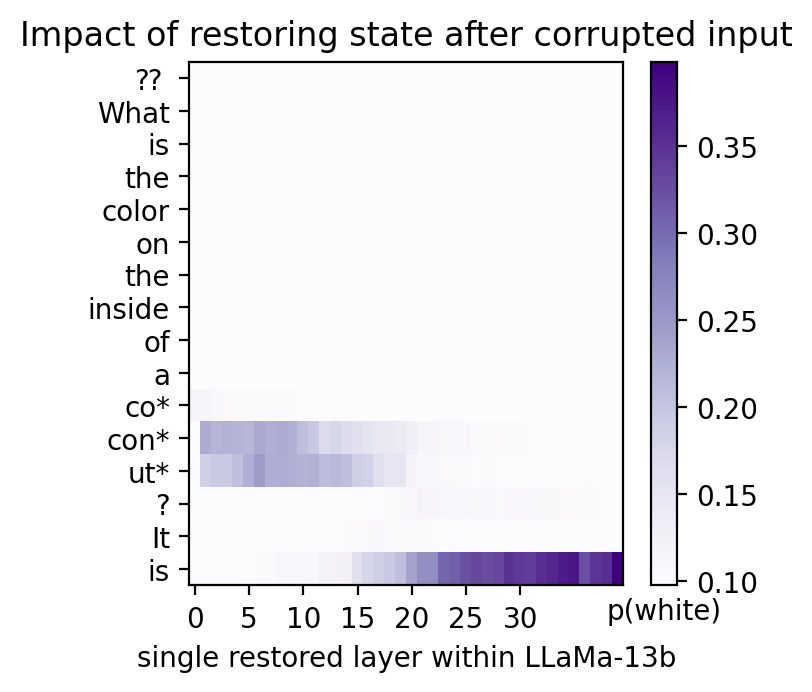

In [26]:
plot_hidden_flow(mt, prompt_2, subject, modelname = "LLaMa-13b")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

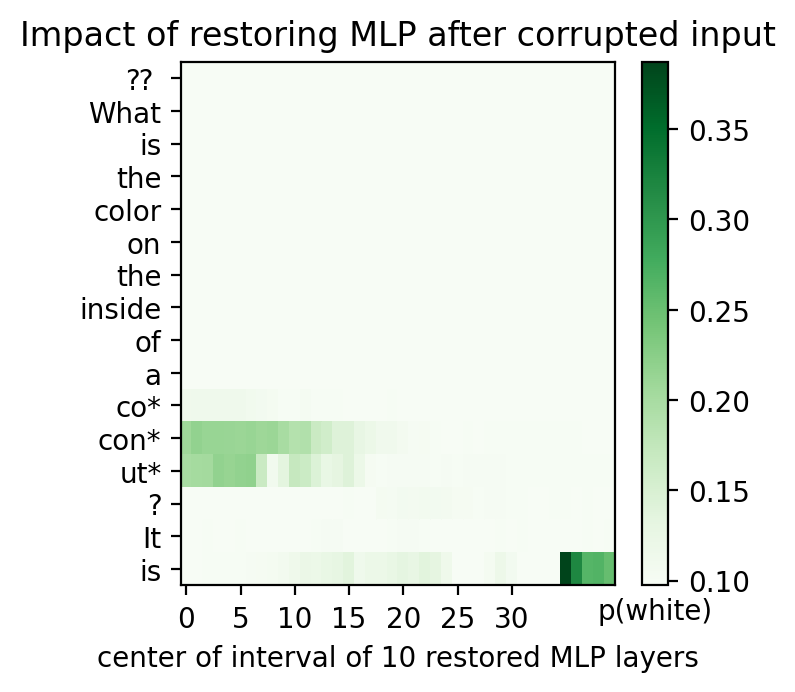

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

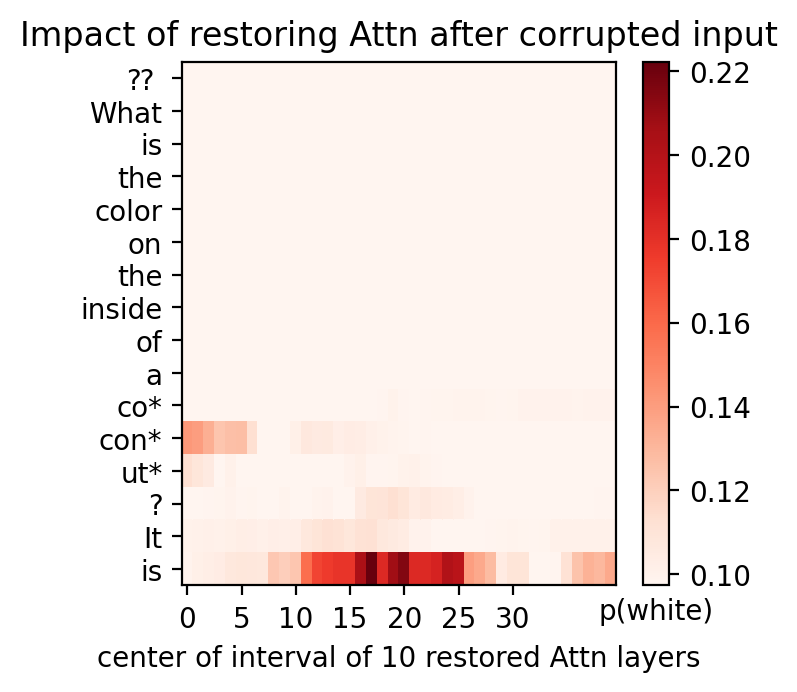

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

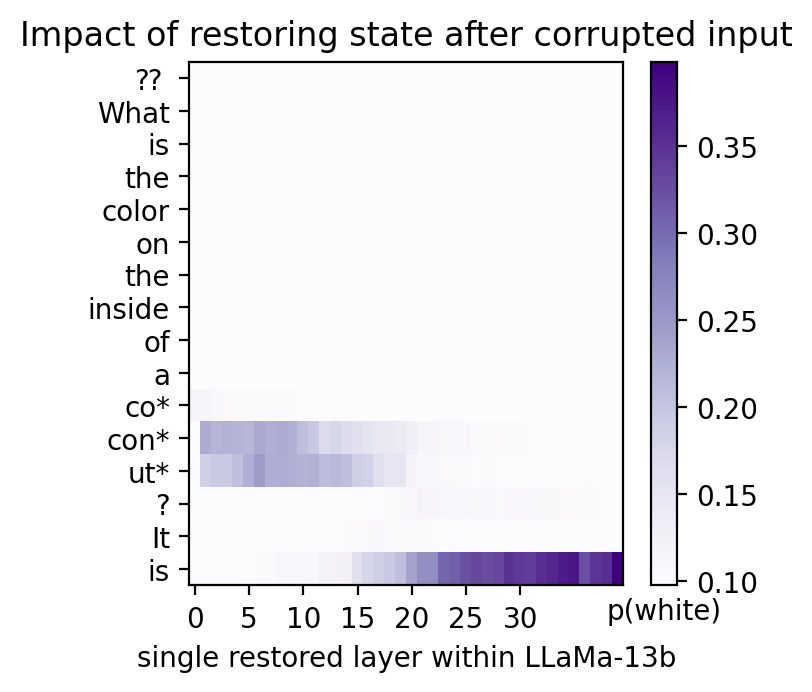

In [29]:
plot_all_flow(mt, prompt_2, subject, modelname = "LLaMa-13b")

## Adapting the `estimate` and `corner` moduels to support `LLaMa`

In [13]:
colors = [
    "purple", "blue", "green", "yellow", 
    "orange", "red", "violet", "white", 
    "black", "pink", "brown", "grey"
]

for c in colors:
    word = c
    tok_ids = tokenizer(word).input_ids
    print(list(zip(tok_ids, [tokenizer.decode(t) for t in tok_ids])))

[(0, '<unk>'), (3708, 'pur'), (552, 'ple')]
[(0, '<unk>'), (7254, 'blue')]
[(0, '<unk>'), (7933, 'green')]
[(0, '<unk>'), (13328, 'yellow')]
[(0, '<unk>'), (24841, 'orange')]
[(0, '<unk>'), (2654, 'red')]
[(0, '<unk>'), (28008, 'vio'), (1026, 'let')]
[(0, '<unk>'), (4796, 'white')]
[(0, '<unk>'), (4628, 'black')]
[(0, '<unk>'), (282, 'p'), (682, 'ink')]
[(0, '<unk>'), (17354, 'brown')]
[(0, '<unk>'), (18345, 'grey')]


In [23]:
ln_f_name = "model.norm"
unembedder_module_name = "lm_head"

ln_f = baukit.get_module(model, ln_f_name)
unembedder = baukit.get_module(model, unembedder_module_name)

In [24]:
from relations.corner import CornerEstimator

corner_estimator = CornerEstimator(
    model, tokenizer,
    ln_f_name = "model.norm", unembedder_module_name = "lm_head",
    idx = 1
)

In [25]:
corner_estimator.get_vocab_representation(misc.untuple(traces[z_layer_name].output)[0][-1], get_logits = True)

[('red', 11.727),
 ('a', 9.031),
 ('green', 8.914),
 ('yellow', 8.562),
 ('not', 8.484)]

In [26]:
z = misc.untuple(traces[z_layer_name].output)[0][-1]
print(z.shape)

logits = unembedder(ln_f(z))
print(logits.shape)

torch.Size([5120])
torch.Size([32000])


In [27]:
target_tokenized = tokenizer(colors, padding=True, return_tensors="pt").to(model.device)
target_tokenized.input_ids

tensor([[    0,  3708,   552],
        [    0,  7254, 32000],
        [    0,  7933, 32000],
        [    0, 13328, 32000],
        [    0, 24841, 32000],
        [    0,  2654, 32000],
        [    0, 28008,  1026],
        [    0,  4796, 32000],
        [    0,  4628, 32000],
        [    0,   282,   682],
        [    0, 17354, 32000],
        [    0, 18345, 32000]], device='cuda:0')

In [28]:
target_tokens = torch.tensor([t[1].item() for t in target_tokenized.input_ids]).to(model.device)
target_tokens

tensor([ 3708,  7254,  7933, 13328, 24841,  2654, 28008,  4796,  4628,   282,
        17354, 18345], device='cuda:0')

In [29]:
torch.gather(logits, 0, target_tokens)

tensor([ 6.9883,  6.7656,  8.9141,  8.5625,  7.8750, 11.7266,  3.2949,  7.1406,
         5.6250,  6.8711,  7.6328,  3.3652], device='cuda:0',
       dtype=torch.float16)

/data/arnab_sen_sharma/Projects/relations/notebooks/../relations/corner.py:155: UserWarning: 
                model.dtype == torch.float16
                the unembedder head will be typecasted to float32 in order to avoid precision underflows.
                
  warnings.warn(


initial representation:  [('otr', 7.645), ('ugen', 7.019), ('tex', 6.896), ('usa', 6.725), ('illi', 6.545)]


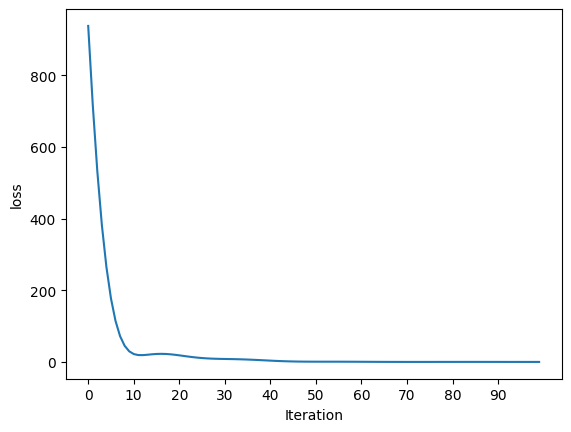

final representation:  [('orange', 30.156), ('yellow', 30.078), ('red', 30.078), ('blue', 30.078), ('green', 30.047)]


In [30]:
corner = corner_estimator.estimate_corner_with_gradient_descent(
    target_words = colors, target_logit_value = 30, verbose = True
)

In [31]:
from relations import estimate

In [82]:
subject = "watermelon"
relation = icl_inside

rop, _ = estimate.relation_operator_from_sample(
    model, tokenizer,
    subject = subject, relation = relation,
    layer = 20,
    
    layer_name_format = "model.layers.{}",
    ln_f_name = "model.norm",
    unembedder_module_name = "lm_head",
    n_layer_field = 'num_hidden_layers',
    device = "cuda:0"
)

subject_range >>  31 35
h_token_index >>  34
model.embed_tokens.weight  ::  torch.Size([32000, 5120])  ::  False
inside insert_h >>  True False


/data/arnab_sen_sharma/Projects/relations/notebooks/../relations/estimate.py:281: UserWarning: The model `<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.
  use_cache = False


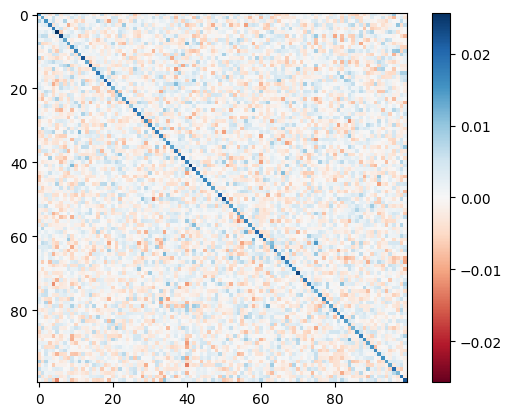

In [83]:
misc.visualize_matrix(rop.weight)

In [84]:
corner_estimator.get_vocab_representation(rop.bias, get_logits = True)

[('red', 18.531),
 ('white', 17.922),
 ('p', 17.828),
 ('green', 16.359),
 ('yellow', 16.047)]

In [85]:
rop_2, _ = estimate.relation_operator_from_sample(
    model, tokenizer,
    subject = subject, relation = relation,
    layer = 20,
    
    layer_name_format = "model.layers.{}",
    ln_f_name = "model.norm",
    unembedder_module_name = "lm_head",
    n_layer_field = 'num_hidden_layers',
    device = "cuda:1",
    calculate_J_sequentially_row_by_row = True
)


subject_range >>  31 35
h_token_index >>  34
h >>  torch.Size([5120]) True
model.embed_tokens.weight  ::  torch.Size([32000, 5120])  ::  True
inside insert_h >>  True True
z >>  torch.Size([5120]) True
Calculating Jacobians ...


  0%|          | 0/5120 [00:00<?, ?it/s]

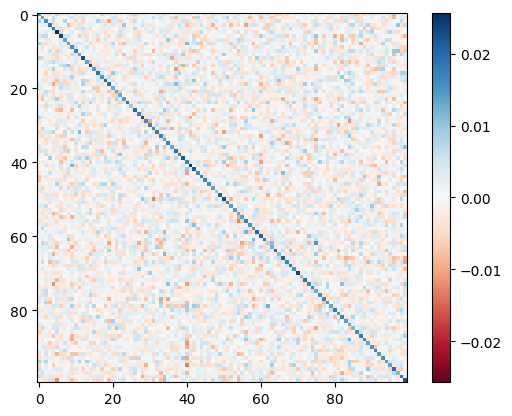

In [86]:
misc.visualize_matrix(rop_2.weight)

In [87]:
corner_estimator.get_vocab_representation(rop_2.bias, get_logits = True)

[('red', 18.531),
 ('white', 17.922),
 ('p', 17.828),
 ('green', 16.359),
 ('yellow', 16.047)]

In [89]:
torch.dist(rop.weight, rop_2.weight.to(rop.weight.device))

tensor(0.0303, device='cuda:0', dtype=torch.float16)

## Averaging multiple `relation_operators`

In [90]:
from tqdm.auto import tqdm

In [110]:
train_samples = ["watermelon", "coconut"]
layer = 17


inside_weights = []
outside_weights = []

for fruit in tqdm(train_samples):
    rop_inside, _ = estimate.relation_operator_from_sample(
        model, tokenizer,
        subject = fruit, relation = icl_inside,
        layer = layer,
        layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
        unembedder_module_name = "lm_head", n_layer_field = 'num_hidden_layers',
        device = "cuda:0"
    )
    inside_weights.append(rop_inside)
    
    rop_outside, _ = estimate.relation_operator_from_sample(
        model, tokenizer,
        subject = fruit, relation = icl_outside,
        layer = layer,
        layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
        unembedder_module_name = "lm_head", n_layer_field = 'num_hidden_layers',
        device = "cuda:0"
    )
    outside_weights.append(rop_outside)

  0%|          | 0/2 [00:00<?, ?it/s]

/data/arnab_sen_sharma/Projects/relations/notebooks/../relations/estimate.py:279: UserWarning: The model `<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>` can't utilize `use_cache` for fast generation. Setting `use_cache = False`.
  break


In [139]:
color_inside = estimate.RelationOperator(
    model = model, tokenizer= tokenizer,
    relation = icl_inside, layer = layer,
    weight = torch.stack(
        [wb.weight for wb in inside_weights]
    ).mean(dim=0),
#     bias = corner,
    bias = torch.stack([wb.bias for wb in inside_weights]).mean(dim=0),
    layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
    unembedder_module_name = "lm_head",
)

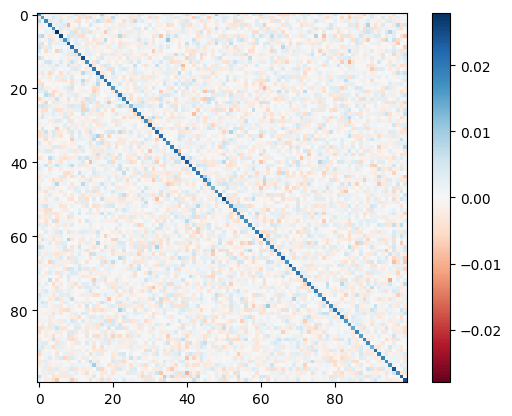

In [140]:
misc.visualize_matrix(color_inside.weight)

In [141]:
corner_estimator.get_vocab_representation(
    torch.stack([wb.bias for wb in inside_weights]).mean(dim=0), 
    get_logits = True
)

[('white', 19.188),
 ('p', 17.031),
 ('red', 17.016),
 ('yellow', 17.0),
 ('green', 16.5)]

In [152]:
color_inside(
    subject = "lime",
    subject_token_index = -1, device = "cuda:0", return_top_k = 5
)

['white', 'yellow', 'red', 'p', 'green']

In [144]:
color_outside = estimate.RelationOperator(
    model = model, tokenizer= tokenizer,
    relation = icl_inside, layer = layer,
    weight = torch.stack(
        [wb.weight for wb in outside_weights]
    ).mean(dim=0),
#     bias = corner,
    bias = torch.stack([wb.bias for wb in outside_weights]).mean(dim=0),
    layer_name_format = "model.layers.{}", ln_f_name = "model.norm", 
    unembedder_module_name = "lm_head",
)

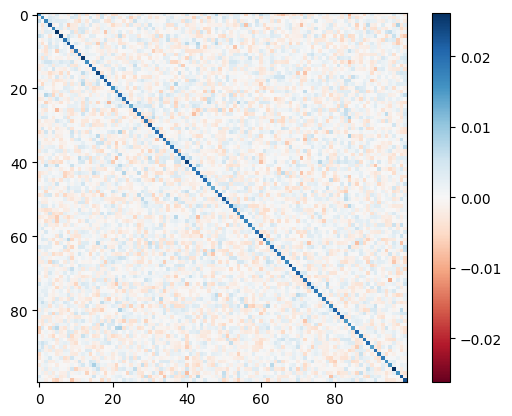

In [145]:
misc.visualize_matrix(color_outside.weight)

In [146]:
corner_estimator.get_vocab_representation(
    torch.stack([wb.bias for wb in outside_weights]).mean(dim=0), 
    get_logits = True
)

[('green', 18.922),
 ('brown', 17.641),
 ('white', 16.703),
 ('yellow', 16.656),
 ('red', 16.25)]

In [150]:
color_outside(
    subject = "lime",
    subject_token_index = -1, device = "cuda:0", return_top_k = 5
)

['green', 'brown', 'yellow', 'white', 'red']

In [148]:
torch.dist(color_inside.weight, color_outside.weight)

tensor(9., device='cuda:0', dtype=torch.float16)